In [33]:
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)

from matplotlib import pyplot as plt
%matplotlib notebook

## Data generation
We need a function which can generate with the proper structure.

The data structure is a list of binary module vectors per track

In [4]:
# Config parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)

<IPython.core.display.Javascript object>


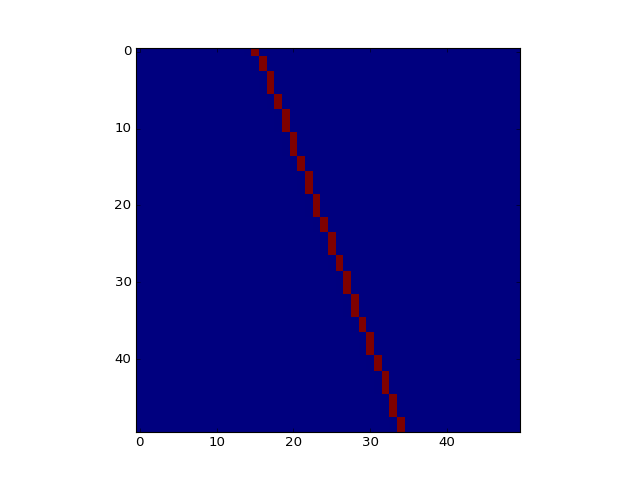

In [13]:
# This is what a track looks like in our "detector"
t = generate_straight_track(det_shape)
plt.figure()
plt.imshow(t, interpolation='none')

In [7]:
# Generate a sample of these single-track events
tracks = generate_straight_tracks(50000, det_shape)
train_input = tracks[:,:-1,:]
train_target = tracks[:,1:,:]
print(train_input.shape)

(50000, 49, 50)


## Build the track fitting model

In [8]:
def build_model(num_hidden=10, length=det_depth-1, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [9]:
# Instantiate the model
model1 = build_model()
# Train on the entire training set
model1.fit(train_input, train_target, batch_size=100, nb_epoch=10)
# Get all of the training data predictions
train_pred = model1.predict(train_input)

Epoch 1/10
50000/50000 [==============================] - 120s - loss: 2.3357 - acc: 0.3750   
Epoch 2/10
50000/50000 [==============================] - 120s - loss: 1.0781 - acc: 0.6732   
Epoch 3/10
50000/50000 [==============================] - 120s - loss: 0.8136 - acc: 0.6995   
Epoch 4/10
50000/50000 [==============================] - 120s - loss: 0.7010 - acc: 0.7233   
Epoch 5/10
50000/50000 [==============================] - 122s - loss: 0.6309 - acc: 0.7411   
Epoch 6/10
50000/50000 [==============================] - 120s - loss: 0.5811 - acc: 0.7576   
Epoch 7/10
50000/50000 [==============================] - 120s - loss: 0.5431 - acc: 0.7735   
Epoch 8/10
50000/50000 [==============================] - 120s - loss: 0.5139 - acc: 0.7855   
Epoch 9/10
50000/50000 [==============================] - 119s - loss: 0.4916 - acc: 0.7956   
Epoch 10/10
50000/50000 [==============================] - 120s - loss: 0.4738 - acc: 0.8017   


<IPython.core.display.Javascript object>


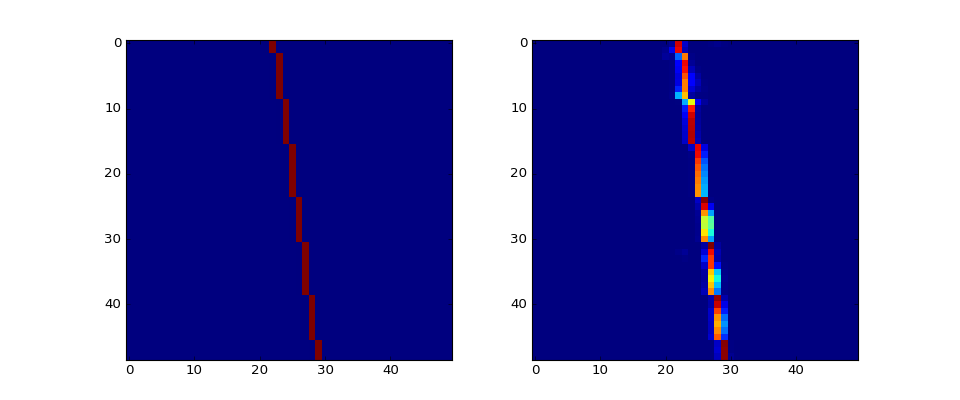

In [14]:
# Display one sample from the training set
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(train_input[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train_pred[display_idx], interpolation='none')

## Two-track events

<IPython.core.display.Javascript object>


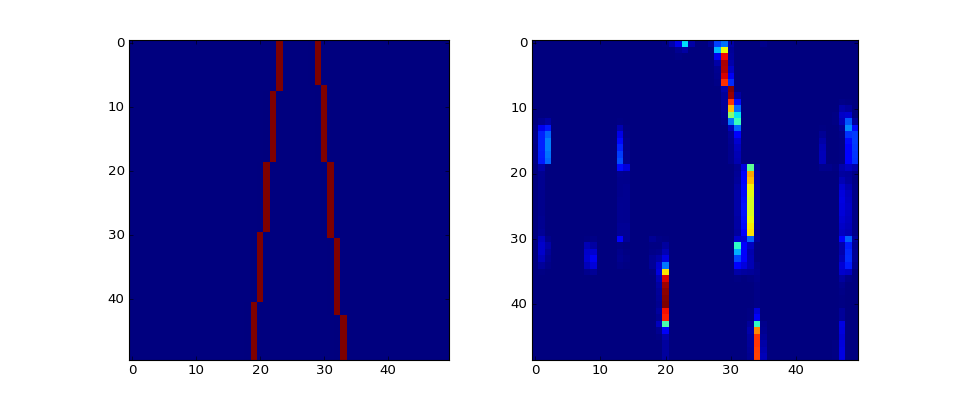

In [15]:
# Try adding two tracks into one image and see how the model does without any retraining
t1 = generate_straight_track(det_shape)
t2 = generate_straight_track(det_shape)
t3 = t1 + t2
t3_input = np.expand_dims(t3, 0)[:,:-1,:]
t3_pred = model1.predict(t3_input)

# Plot the event and the corresponding prediction
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(t3, interpolation='none')
plt.subplot(122)
plt.imshow(t3_pred[0], interpolation='none')

In [16]:
# Now lets generate events with 2 tracks each and train on that
events2 = sum([generate_straight_tracks(50000, det_shape) for i in range(2)])
#events2 = generate_events(50000, 2)
train2_input = events2[:,:-1,:]
train2_target = events2[:,1:,:]

In [17]:
# Create a new model
model2 = build_model(num_hidden=20)
model2.fit(train2_input, train2_target, batch_size=100, nb_epoch=10)
train2_pred = model2.predict(train2_input)

Epoch 1/10
50000/50000 [==============================] - 126s - loss: 4.8204 - acc: 0.2690   
Epoch 2/10
50000/50000 [==============================] - 127s - loss: 3.3007 - acc: 0.3502   
Epoch 3/10
50000/50000 [==============================] - 126s - loss: 3.1586 - acc: 0.3505   
Epoch 4/10
50000/50000 [==============================] - 128s - loss: 3.0936 - acc: 0.3509   
Epoch 5/10
50000/50000 [==============================] - 128s - loss: 3.0491 - acc: 0.3524   
Epoch 6/10
50000/50000 [==============================] - 127s - loss: 3.0159 - acc: 0.3540   
Epoch 7/10
50000/50000 [==============================] - 127s - loss: 2.9889 - acc: 0.3562   
Epoch 8/10
50000/50000 [==============================] - 128s - loss: 2.9663 - acc: 0.3576   
Epoch 9/10
50000/50000 [==============================] - 128s - loss: 2.9466 - acc: 0.3596   
Epoch 10/10
50000/50000 [==============================] - 128s - loss: 2.9293 - acc: 0.3618   


<IPython.core.display.Javascript object>


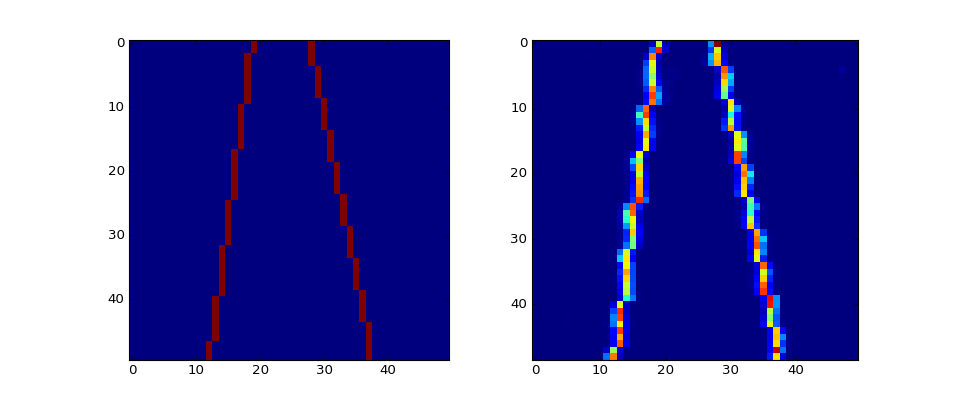

In [18]:
# Display one sample from the training set
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events2[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train2_pred[display_idx], interpolation='none')

## Single tracks with uniform noise
In training, the inputs to the network are the events with the tracks and noise. However, in this case the target is the not same event, but rather the track by itself (still shifted by 1 index). Let's see if we can get this to work.

<IPython.core.display.Javascript object>


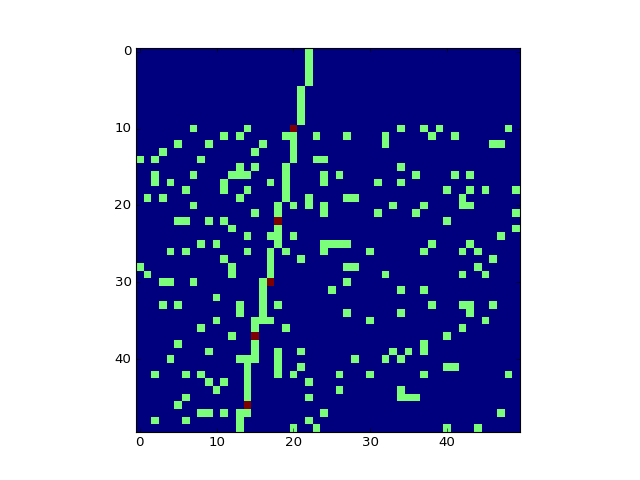

In [23]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=10)
events3 = tracks + noise

# Define the inputs and target
train3_input = events3[:,:-1,:]
train3_target = tracks[:,1:,:]

# Let's take a quick look at one of these noise events
plt.figure()
plt.imshow(events3[66], interpolation='none')

In [24]:
# Instantiate the model
model3 = build_model(num_hidden=20)
# Train the network
model3.fit(train3_input, train3_target, batch_size=100, nb_epoch=10)
# Get the final predictions from the entire training set
train3_pred = model3.predict(train3_input)

Epoch 1/10
50000/50000 [==============================] - 125s - loss: 2.1983 - acc: 0.3396   
Epoch 2/10
50000/50000 [==============================] - 125s - loss: 1.2889 - acc: 0.5441   
Epoch 3/10
50000/50000 [==============================] - 130s - loss: 1.0747 - acc: 0.5976   
Epoch 4/10
50000/50000 [==============================] - 125s - loss: 0.9604 - acc: 0.6254   
Epoch 5/10
50000/50000 [==============================] - 124s - loss: 0.8974 - acc: 0.6423   
Epoch 6/10
50000/50000 [==============================] - 124s - loss: 0.8418 - acc: 0.6576   
Epoch 7/10
50000/50000 [==============================] - 124s - loss: 0.7992 - acc: 0.6701   
Epoch 8/10
50000/50000 [==============================] - 125s - loss: 0.7614 - acc: 0.6830   
Epoch 9/10
50000/50000 [==============================] - 125s - loss: 0.7456 - acc: 0.6904   
Epoch 10/10
50000/50000 [==============================] - 124s - loss: 0.7139 - acc: 0.7005   


<IPython.core.display.Javascript object>


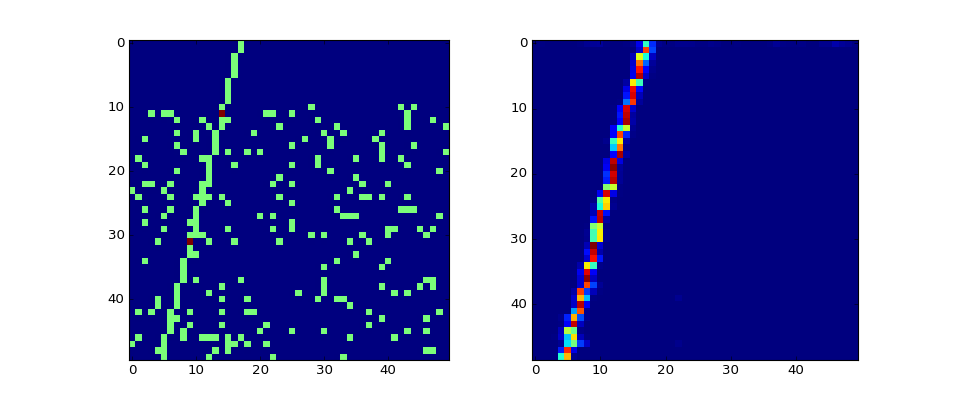

In [25]:
display_idx = 12050
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events3[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train3_pred[display_idx], interpolation='none')

let's try to make it a little more difficult by decreasing the seed size and increasing the noise level

<IPython.core.display.Javascript object>


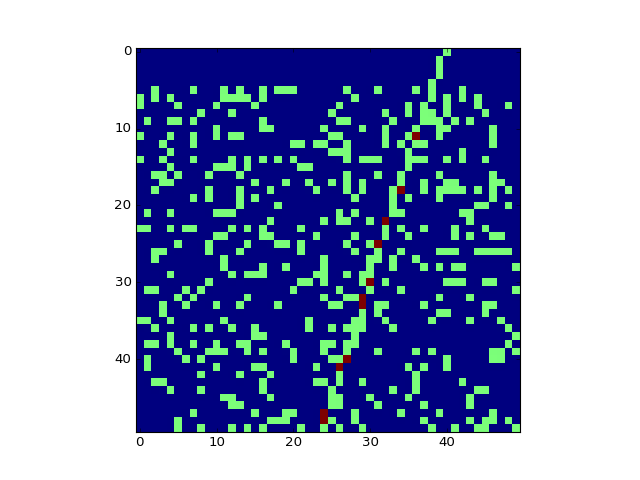

In [26]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=5, prob=0.2)
events4 = tracks + noise
train4_input = events4[:,:-1,:]
train4_target = tracks[:,1:,:]
plt.figure()
plt.imshow(events4[10], interpolation='none')

In [28]:
model4 = build_model(num_hidden=20)
model4.fit(train4_input, train4_target, batch_size=100, nb_epoch=10)
train4_pred = model4.predict(train4_input)

Epoch 1/10
50000/50000 [==============================] - 129s - loss: 2.6591 - acc: 0.2324   
Epoch 2/10
50000/50000 [==============================] - 128s - loss: 1.8301 - acc: 0.3863   
Epoch 3/10
50000/50000 [==============================] - 128s - loss: 1.5754 - acc: 0.4454   
Epoch 4/10
50000/50000 [==============================] - 127s - loss: 1.4073 - acc: 0.4864   
Epoch 5/10
50000/50000 [==============================] - 131s - loss: 1.3692 - acc: 0.5077   
Epoch 6/10
50000/50000 [==============================] - 126s - loss: 1.2917 - acc: 0.5201   
Epoch 7/10
50000/50000 [==============================] - 125s - loss: 1.1910 - acc: 0.5459   
Epoch 8/10
50000/50000 [==============================] - 127s - loss: 1.1343 - acc: 0.5609   
Epoch 9/10
50000/50000 [==============================] - 128s - loss: 1.3930 - acc: 0.5142   
Epoch 10/10
50000/50000 [==============================] - 129s - loss: 1.1721 - acc: 0.5532   


<IPython.core.display.Javascript object>


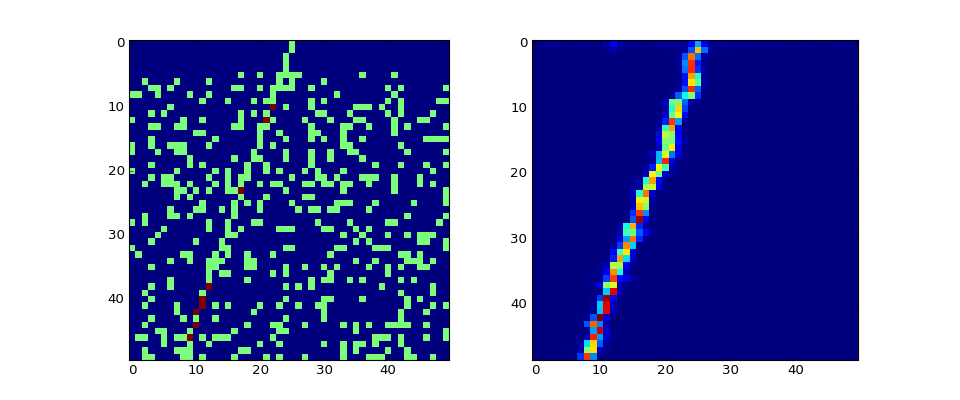

In [29]:
display_idx = 444
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events4[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train4_pred[display_idx], interpolation='none')

<IPython.core.display.Javascript object>


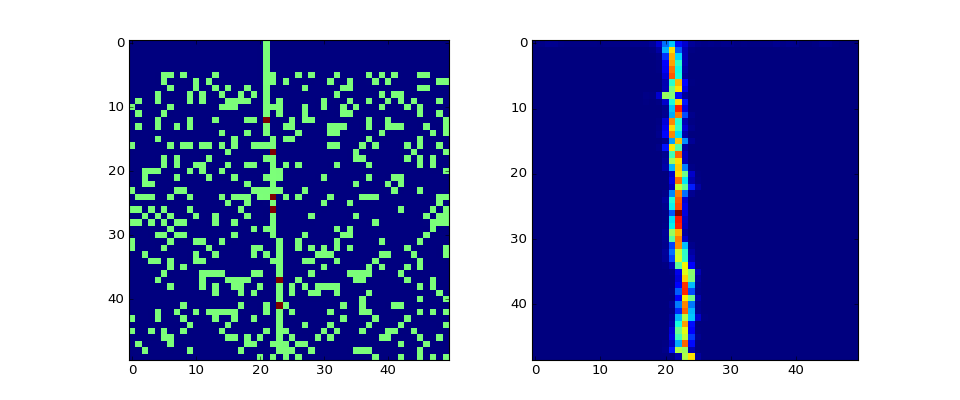

In [30]:
display_idx = 25
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events4[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train4_pred[display_idx], interpolation='none')

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track.

<IPython.core.display.Javascript object>


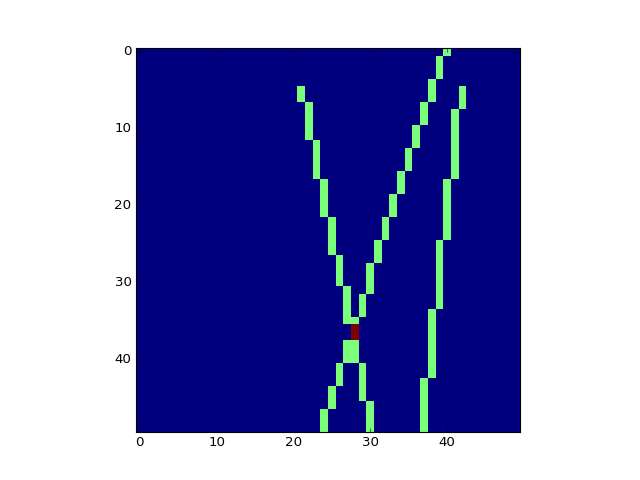

In [34]:
# Generate the bkg data
bkgs = generate_track_bkg(tracks.shape[0], det_shape, tracks_per_event=2)
events5 = bkgs + tracks
train5_input = events5[:,:-1,:]
train5_target = tracks[:,1:,:]
plt.figure()
plt.imshow(events5[10], interpolation='none')

In [35]:
model5 = build_model(num_hidden=50)
model5.fit(train5_input, train5_target, batch_size=100, nb_epoch=20)
train5_pred = model5.predict(train5_input)

Epoch 1/20
50000/50000 [==============================] - 143s - loss: 2.3806 - acc: 0.3494   
Epoch 2/20
50000/50000 [==============================] - 145s - loss: 1.6526 - acc: 0.4930   
Epoch 3/20
50000/50000 [==============================] - 140s - loss: 1.3936 - acc: 0.5441   
Epoch 4/20
50000/50000 [==============================] - 141s - loss: 1.2353 - acc: 0.5745   
Epoch 5/20
50000/50000 [==============================] - 143s - loss: 1.1311 - acc: 0.5981   
Epoch 6/20
50000/50000 [==============================] - 144s - loss: 1.0578 - acc: 0.6176   
Epoch 7/20
50000/50000 [==============================] - 145s - loss: 1.1993 - acc: 0.6012   
Epoch 8/20
50000/50000 [==============================] - 141s - loss: 1.0882 - acc: 0.6182   
Epoch 9/20
50000/50000 [==============================] - 139s - loss: 0.9833 - acc: 0.6399   
Epoch 10/20
50000/50000 [==============================] - 140s - loss: 0.9692 - acc: 0.6453   
Epoch 11/20
50000/50000 [========================

<IPython.core.display.Javascript object>


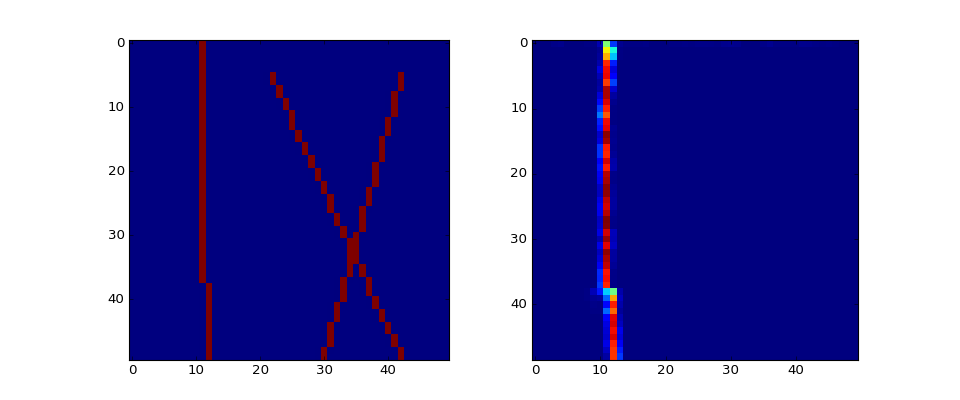

In [36]:
display_idx = 1234
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events5[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train5_pred[display_idx], interpolation='none')

<IPython.core.display.Javascript object>


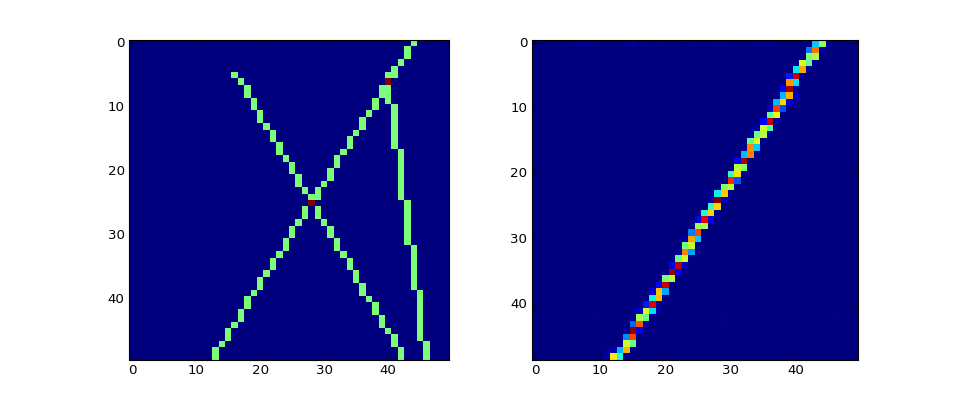

In [37]:
display_idx = 5432
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events5[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train5_pred[display_idx], interpolation='none')

<IPython.core.display.Javascript object>


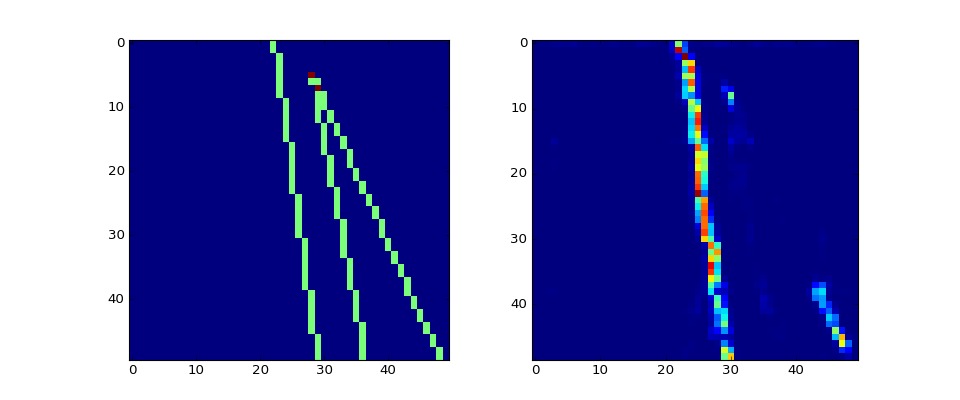

In [38]:
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events5[display_idx], interpolation='none')
plt.subplot(122)
plt.imshow(train5_pred[display_idx], interpolation='none')